# Project 2 Analysis

## Create Dataframe from CSV

In [69]:
import pandas as pd
pd.options.mode.chained_assignment = None

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

df = pd.read_csv("turnstile_data_master_with_weather.csv")

## Section 1 - Statistical Tests
When evaluating the difference between of the means of ridership on rainy days versus non rainy days a Mann Whitney U test was chosen as the distibutions were non parametric. As the visualizations show below the distributions are similar in shape as well. The null hypothesis under consideration is that the median ridership between rainy and non rainy days were equal. We will be testing as two tailed test with a p value at the 5% significance level.

$$
H_{O}:\text{The distribution of ridership on rainy and non rainy days are identical} \\
H_{A}: \text{The medians of the two groups are not equal}
$$


In [70]:
rain_df = df[['ENTRIESn_hourly', 'rain']]
rain_dict = {0:"Rain", 1:"No Rain"}
rain_df = rain_df.replace({"rain":rain_dict})
rain_df.groupby("rain").describe()

ENTRIESn_hourly
rain                          
No Rain count     44104.000000
        mean       1105.446377
        std        2370.527674
        min           0.000000
        25%          41.000000
        50%         282.000000
        75%        1103.250000
        max       51839.000000
Rain    count     87847.000000
        mean       1090.278780
        std        2320.004938
        min           0.000000
        25%          38.000000
        50%         278.000000
        75%        1111.000000
        max       43199.000000

### Results
Please see R results belows and full explanation as to my issues with sklearn. From the simple analysis above though it does seem like the mean and max ridership vary between rainy days and non rainy days.

## Section 2 -Stochastic Gradient Descent
I tried to fit a linear model with Stochastic Gradient Descent solely for the reason to learn more about the Stochastic Gradient Descent technique. For this linear regression I have chosen the two variables listed below. At time of writing I am using intuition to decide what parameters may be associated with ridership.

Numerous pairings were tested with the weather, all with very little success. However dummy columns were created for the hour of entry and the unit. It was assumed that the unit generally corresponded to stations. However as bigger stations may have more than one unit, this column may be biasing entries. Nonetheless after adding it to the model it does seem to explain some of the variability.

The last engineered variable was the week or weekend categorical variable. It is likely that ridership is affected by the US work week. To add this to the regression the date was converted to a numerical representation, then Saturday and Sunday were converted to a factor of 1, and weekdays 0:

In [71]:
# Create a features dataframe
f_df = df[["Hour", "UNIT"]]
f_df.loc[:,"Hour"] = f_df.loc[:,"Hour"].astype("category")
y = df["ENTRIESn_hourly"]

#f_df = df[["UNIT"]]
#Make Dummy columns for Hours and Train Station
f_df = pd.get_dummies(f_df)

#Convert Weekday or Weekend to categorical variable
'''
day = pd.to_datetime(df["DATEn"]).dt.dayofweek.apply(lambda x : float((x  >4)))
day.name = "Weekend"
f_df = f_df.join(day)
'''

X_Names = f_df.columns
f_df.shape

C:\Miniconda3\lib\site-packages\pandas\core\indexing.py:415: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


(131951, 489)

In [72]:
from sklearn.linear_model import SGDRegressor
from sklearn.preprocessing import StandardScaler, MinMaxScaler

In [73]:
# Scale Inputs
# Not needed for this selected features as all features are binary
scaler = MinMaxScaler()
features_train_scaled = scaler.fit_transform(f_df.values)

In [74]:
clf = SGDRegressor(n_iter=100, alpha=0.0001, random_state=123)
clf = clf.fit(f_df.values, y.values)

#print("Stochastic Descent Feature coefficients")
#print(dict(zip(X_Names, clf.coef_,)))
#print(clf.intercept_)
print("R Score")
print(clf.score(f_df.values, y.values))

R Score
0.499157994293


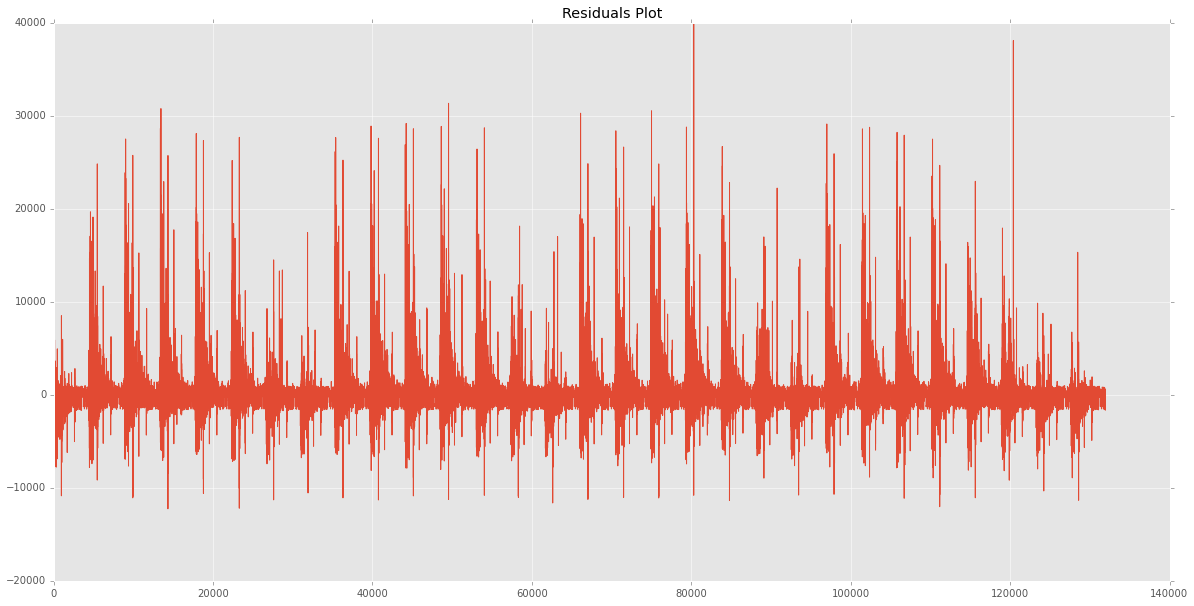

In [75]:
plt.figure(figsize=(20,10)) 
plt.plot(y.values-clf.predict(f_df.values))
plt.title("Residuals Plot")

When testing weather effects a the Goodness of Fit value was quite low, close to zero. The low Goodness of Fit value indicated that the features chosen had very little predictive power of the outcome variable.

It was decided to try and use the features of hours, day of the week, and units to predict ridership. None of these columns lent themselves regression out of the box. All three features required some preprocessing steps to turn them from linear values into categorical variables. The day of the week required some datetime processing to be recoded into a 0 and 1 factor for weekday or weekend. Ultimately though the feature engineering lead to better results yielding a .49 Coefficient of Determination, much greater than any regression found by myself through regression.

When plotting the residuals it becomes evident that they are not distributed normally. The residuals seem to show some cyclical effects and although it won't be pursued in this analysis, an OLS does not seem to be the best fit for this data.

An attempt was made to avoid "Kitchen Sink Regression" as the coefficient of determination monotonically increases with the number of features added but may not actually lead to a better model.

https://en.wikipedia.org/wiki/Kitchen_sink_regression

## Section 3 - Visualizations 

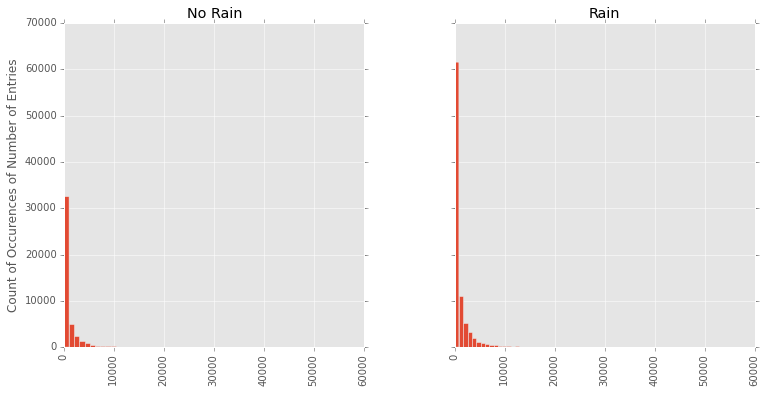

In [76]:
a = rain_df.hist(by = 'rain', sharex = True, sharey = True,  figsize = (12, 6), bins = 50)
#Need to set labels independently
a[0].set_ylabel("Count of Occurences of Number of Entries")

### Revised Histogram
Due to outliers stretching the histogram is displayed again below with a smaller X Axis. While the distribution peaks look different it's actually because the binning range has decreased, splitting the larger bins above into smaller bins.

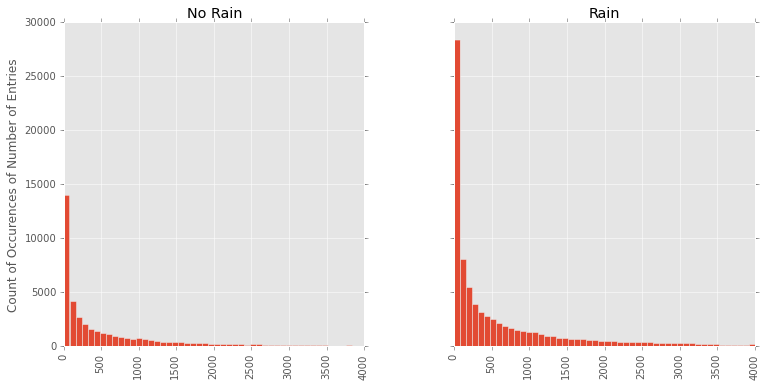

In [77]:
a = rain_df[rain_df["ENTRIESn_hourly"] < 4000].hist(by = 'rain', sharex = True, sharey= True, figsize = (12, 6), bins = 50)
a[0].set_ylabel("Count of Occurences of Number of Entries")

### Additional Exploratory Visualizations
Curious to see when peak traffic occurrs

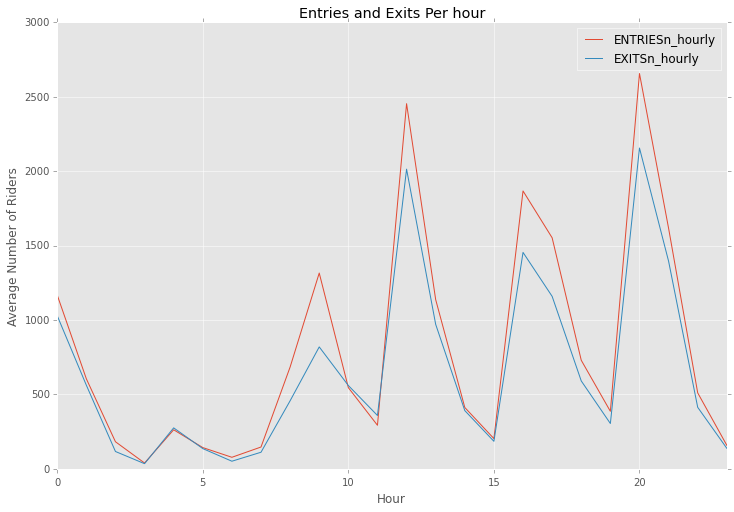

In [78]:
ax = df[['Hour', 'ENTRIESn_hourly', 'EXITSn_hourly']].groupby('Hour').mean().plot(kind= "line", figsize = (12, 8),\
        title = "Entries and Exits Per hour")
ax.set_ylabel("Average Number of Riders")

### Section 4 Conclusion
Please see below for my comments about the difference in distributions using the Mann and Whitney U test

### Reflection
There were two datasets provided for this project, an original, and an improved dataset. The original dataset had 131951 values and 22 columns whereas the improved dataset has 42650 rows and 27 columns. For this notebook I used the original dataset.

The dataset had all the values necessary. For the rain column the 0 and 1 values needed to be recoded to aid the histogram generation. Otherwise the dataset was fairly self explanatory. 

For the analysis it was difficult with inuition to find variables that correlated with ridership with either method. Stochastic gradient decesnt was chosen solely for the purpose of learning for the notebook creator. One consideration however was the speed Gradient Descent holds when attempting to regress over many features versus linear regression which can become very slow as feater size gets large. However some values such as the learning rate and iterations were chosen at random. Feature scaling was performed to attempt to normalize all the inputs variables.

When selecting features, the weather features seemed to explain very little of the variability in ridership. Turning hours, days, and units into categorical variables yielded much better results.

### Appendix
##### Linear Model
Linear Model in sklearn for reference

In [79]:
from sklearn.linear_model import LinearRegression

# Create a function to fit models
def fit_lm(f_df, y):
    clf = LinearRegression()
    X_Names = f_df.columns
    
    #Scale Inputs
    scaler = StandardScaler()
    features_train_scaled = scaler.fit_transform(f_df.values)
    
    #Only need Vstack is creating regression with one feature
    clf = clf.fit(np.vstack(f_df.values), y)
    
    print("Linear Feature coefficients")
    print(dict(zip(X_Names, clf.coef_,)))
    print(clf.intercept_)
    return

#### Issues with SKLearn and Mann Whitney Test
The Mann Whitney test is causing issues on my particular computer in Python. It seems that the sklearn module from my computer is causing issues for me and other students. I ran the program in R and fained other values, even ones that are different than what my evalution said they should be. See below

https://discussions.udacity.com/t/mann-whitney-u-test-on-improved-dataset-yields-p-nan/4470

In [80]:
from scipy.stats import mannwhitneyu

for file in ["turnstile_data_master_with_weather.csv", "turnstile_weather_v2.csv" ]:
    df = pd.read_csv(file)
    rain_df = df[['ENTRIESn_hourly', 'rain']]
    values = [sub_df['ENTRIESn_hourly'] for name, sub_df in rain_df.groupby('rain')]
    
    #Check for significance level
    print(mannwhitneyu(*values))

MannwhitneyuResult(statistic=1924409167.0, pvalue=0.019309634413792565)
MannwhitneyuResult(statistic=153635120.5, pvalue=nan)


#### R Code
<img src="RWilcoxTest.png">

I'll comment based on the results from R, which I understand should be correct regardless of system setup. In my case I will be using the original dataset to remain consistent with the rest of my notebook.

At the 5% significance value I would reject the null hypothesis that the distributions of entries on rainy days and entries on non rainy days are similar.

## Documentation used

* http://pandas.pydata.org/pandas-docs/stable/reshaping.html
* http://stackoverflow.com/questions/20250771/remap-values-in-pandas-column-with-a-dict
* https://en.wikipedia.org/wiki/Kitchen_sink_regression
* https://stat.ethz.ch/R-manual/R-patched/library/stats/html/wilcox.test.html